In [16]:
import os
import sys
from matplotlib import pyplot as plt
sys.path.append('Lab02_NMT')

import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
import json
import librosa
from librosa import display as ld
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

from neural_network import NN_CATALOG
from dataset.bird_clef import load_wav
from dataset.augmentations import Normalize

In [12]:
bird_tax = pd.read_csv('data/eBird_Taxonomy_v2021.csv', index_col=0)
all_meta = pd.read_csv('data/train_metadata_extended.csv')
with open('data/scored_birds.json') as fin:
    scored_birds = json.load(fin)

In [13]:
all_meta.loc[:, 'secondary_labels'] = all_meta.secondary_labels.apply(eval)
all_meta['target_raw'] = all_meta.secondary_labels + all_meta.primary_label.apply(lambda x: [x])

In [14]:
all_species = sorted(set(all_meta.target_raw.sum()))
species2id = {s: i for i, s in enumerate(all_species)}
id2species = {i: s for i, s in enumerate(all_species)}

all_meta['target'] = all_meta.target_raw.apply(lambda species: [int(s in species) for s in all_species])

In [17]:
train_meta, _ = train_test_split(
    all_meta,
    test_size=0.2,
    random_state=42,
#     stratify=all_target[:, all_target.sum(axis=0) >= 100]
)

In [63]:
data_root = 'data/train_audio/'
toscore_meta = train_meta[train_meta.target.apply(sum) == 1]

### Dataset

In [68]:
class TestDataset(Dataset):
    def __init__(self, data_root, meta_pd, augmentations=None, split_size=30):
        super().__init__()
        self.data_root = data_root
        self.meta_pd = meta_pd
        self.fnames = meta_pd.filename
        self.augmentations = augmentations
        self.split_size = split_size
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fpath = os.path.join(self.data_root, self.fnames[idx])
        wav, sr = load_wav(fpath, 0, 60)
        if self.augmentations:
            wav = self.augmentations(wav, None)
        wav = torch.tensor(wav)
        split_factor = 60 // self.split_size
        wav = wav[:len(wav) // split_factor * split_factor].reshape((split_factor, len(wav) // split_factor))
        
        target = self.meta_pd.iloc[idx].target
        target = torch.tensor(target)
        return wav, target

Алгоритм:

разметить по времени где и какая птица поет

далее использовать эту разметку для обучения

In [65]:
test_dataset = TestDataset(
    data_root,
    toscore_meta, 
    augmentations=Normalize(p=1)
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,   
)

### Model

In [66]:
config_path = 'Lab02_NMT/configs/baseline_config.yaml'
model_path = 'Lab02_NMT/model_save/baseline_23ce93kl/final-model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(config_path) as fin:
    config = yaml.safe_load(fin)

model_config = config['model']
if 'backbone_config' in model_config['params']:
    model_config['params']['backbone_config']['pretrained'] = False
data_config = config['data']
model_class = NN_CATALOG[model_config['name']]

model = model_class(len(all_species), int(data_config['crop_len'] // data_config['test_wav_len']),
                    **model_config['params'])
model.to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
test_birds = list(set(test_meta.target_raw.sum()))
test_birds = sorted(test_birds)

In [ ]:
def find_topk(pred_proba, max_birds=3):
    pred_proba = pred_proba[:, [species2id[b] for b in test_birds]]
    mean_proba = pred_proba.mean(axis=0)
    topk_birds = [i for i, _ in sorted(enumerate(mean_proba),
                                       key=lambda x: x[1],
                                       reverse=True)][:max_birds]
    return topk_birds

In [57]:
pred_list = []
treshold = 0.1
model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader)):
        batch_size, part_count, part_size = batch.shape
        batch = batch.reshape(batch_size * part_count, part_size)
        pred = model(batch.to(device))['logits']
        pred = pred.cpu().numpy()
#         pred = pred > treshold
        
        for j, chunk_pred in enumerate(pred):
            inbatch_number = j // part_count
            chunk_number = j % part_count + 1
            f_idx = i * test_dataloader.batch_size + inbatch_number
            
            fname = test_dataset.fnames[f_idx]
            
            pred_list.extend([{
                'filename': fname,
                'right': 5 * chunk_number,
                'left': 5 * chunk_number - 5,
                'bird': b,
                'pred': chunk_pred[species2id[b]]
            } for b in test_birds])
pred_pd = pd.DataFrame(pred_list)

361it [00:59,  6.09it/s]


In [16]:
pred_pd.to_csv('eff_pred.csv', index=False)

['apapan', 'iiwi', 'warwhe1', 'akepa1']
['afrsil1' 'akekee' 'akepa1' 'akiapo' 'amewig' 'aniani' 'apapan' 'arcter'
 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra' 'blknod'
 'bongul' 'brant' 'brnboo' 'brnowl' 'brtcur' 'buffle' 'bulpet' 'burpar'
 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas' 'caster1' 'categr' 'chukar'
 'cintea' 'comgal1' 'commyn' 'compea' 'comsan' 'comwax' 'crehon' 'dunlin'
 'elepai' 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe'
 'grbher3' 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcre' 'hawhaw'
 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1' 'jabwar'
 'japqua' 'kalphe' 'laugul' 'lcspet' 'leasan' 'leater1' 'lessca' 'lesyel'
 'lobdow' 'lotjae' 'madpet' 'magpet1' 'mallar3' 'maupar' 'merlin' 'mitpar'
 'moudov' 'norcar' 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama'
 'omao' 'osprey' 'pagplo' 'parjae' 'pecsan' 'peflov' 'perfal' 'pibgre'
 'pomjae' 'reccar' 'redava' 'redjun' 'redpha1' 'refboo' 'rempar' 'rettro'
 'r

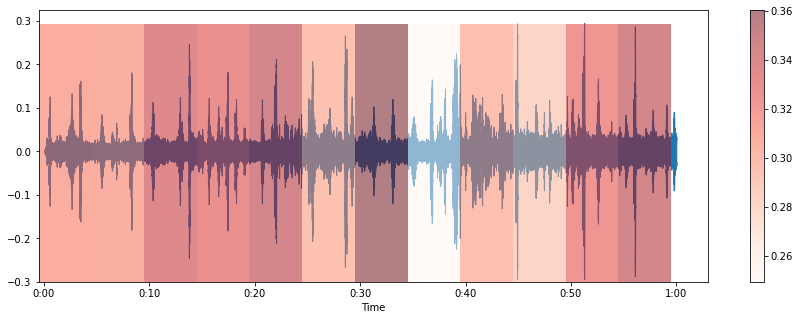

In [138]:
idx = 4
fig, ax = plt.subplots(figsize=(15, 5))
fname = test_meta.iloc[idx]['filename']
fpath = os.path.join('data/train_audio/', fname)
wav, sr = load_wav(fpath, 0, 60)
ld.waveshow(wav, sr=sr, ax=ax)

sample_pred = pred_pd[(pred_pd.filename == fname) & (pred_pd.pred)]
sample_birds = sample_pred.bird.unique()
bird_to_plot = test_meta.iloc[idx]['target_raw'][2]
bird_pred = sample_pred[sample_pred.bird == bird_to_plot]
# bird_pred.loc[:, 'right'] = bird_pred.right * sr
# bird_pred.loc[:, 'left'] = bird_pred.left * sr

# for i, row in bird_pred.iterrows():
#     ax.fill_betweenx(
#         [wav.min(), wav.max()],
#         row.left, row.right,
#         alpha=0.3,
#         color='orange',
#         edgecolor="none"
#     )

nx = 60
x = np.linspace(0,nx-1,nx)
y = np.linspace(wav.min(), wav.max(), 50)
X,Y = np.meshgrid(x, y, indexing='ij')
Z = X * 0 # set a fancy Z function

for i, row in bird_pred.iterrows():
    Z[row.left:row.right, :] = row.pred

# fig = plt.figure(figsize=(22,11)) 
# ax1 = fig.add_subplot(121)
pc = ax.pcolormesh(X, Y, Z, edgecolors='none',cmap="Reds", alpha=0.5)
fig.colorbar(pc)
print(test_meta.iloc[idx]['target_raw'])
print(sample_birds)

['apapan', 'iiwi', 'warwhe1', 'akepa1']
['afrsil1' 'akekee' 'akepa1' 'akiapo' 'amewig' 'aniani' 'apapan' 'arcter'
 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra' 'blknod'
 'bongul' 'brant' 'brnboo' 'brnowl' 'brtcur' 'buffle' 'bulpet' 'burpar'
 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas' 'caster1' 'categr' 'chukar'
 'cintea' 'comgal1' 'commyn' 'compea' 'comsan' 'comwax' 'crehon' 'dunlin'
 'elepai' 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe'
 'grbher3' 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcre' 'hawhaw'
 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1' 'jabwar'
 'japqua' 'kalphe' 'laugul' 'lcspet' 'leasan' 'leater1' 'lessca' 'lesyel'
 'lobdow' 'lotjae' 'madpet' 'magpet1' 'mallar3' 'maupar' 'merlin' 'mitpar'
 'moudov' 'norcar' 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama'
 'omao' 'osprey' 'pagplo' 'parjae' 'pecsan' 'peflov' 'perfal' 'pibgre'
 'pomjae' 'reccar' 'redava' 'redjun' 'redpha1' 'refboo' 'rempar' 'rettro'
 'r

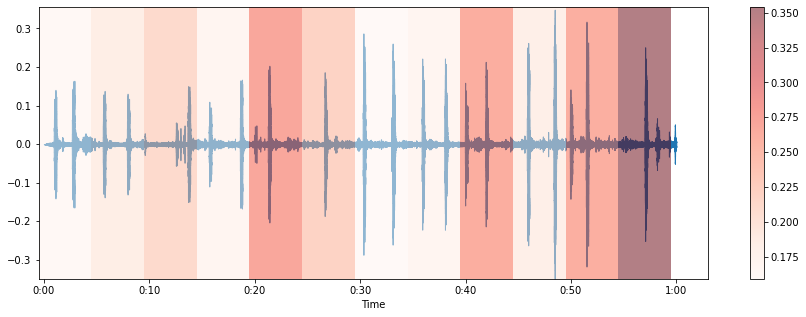

In [18]:
idx = 5
fig, ax = plt.subplots(figsize=(15, 5))
fname = test_meta.iloc[idx]['filename']
fpath = os.path.join('data/train_audio/', fname)
wav, sr = load_wav(fpath, 0, 60)
ld.waveshow(wav, sr=sr, ax=ax)

sample_pred = pred_pd[(pred_pd.filename == fname) & (pred_pd.pred)]
sample_birds = sample_pred.bird.unique()
bird_to_plot = test_meta.iloc[idx]['target_raw'][2]
bird_pred = sample_pred[sample_pred.bird == bird_to_plot]
# bird_pred.loc[:, 'right'] = bird_pred.right * sr
# bird_pred.loc[:, 'left'] = bird_pred.left * sr

# for i, row in bird_pred.iterrows():
#     ax.fill_betweenx(
#         [wav.min(), wav.max()],
#         row.left, row.right,
#         alpha=0.3,
#         color='orange',
#         edgecolor="none"
#     )

nx = 60
x = np.linspace(0,nx-1,nx)
y = np.linspace(wav.min(), wav.max(), 50)
X,Y = np.meshgrid(x, y, indexing='ij')
Z = X * 0 # set a fancy Z function

for i, row in bird_pred.iterrows():
    Z[row.left:row.right, :] = row.pred

# fig = plt.figure(figsize=(22,11)) 
# ax1 = fig.add_subplot(121)
pc = ax.pcolormesh(X, Y, Z, edgecolors='none',cmap="Reds", alpha=0.5)
fig.colorbar(pc)
print(test_meta.iloc[idx]['target_raw'])
print(sample_birds)

In [19]:
per_wav_stat = pred_pd.groupby(['filename', 'bird']).agg(
    mean=('pred', np.mean),
    std=('pred', np.std),
).reset_index()

per_wav_stat['rank'] = per_wav_stat.groupby('filename')['mean'].rank(ascending=False)

In [20]:
per_wav_stat = per_wav_stat.merge(test_meta[['filename', 'target_raw']], on='filename')
gt_stat = per_wav_stat[per_wav_stat.apply(lambda x: x.bird in x.target_raw, axis=1)]

In [21]:
per_bird_stat = gt_stat.groupby('bird').agg(
    mean=('mean', np.mean),
    std=('std', np.mean),
    rank=('rank', np.mean),
    f_count=('filename', 'count')
)

In [22]:
per_bird_stat.to_csv('eff_stat.csv', index=True)

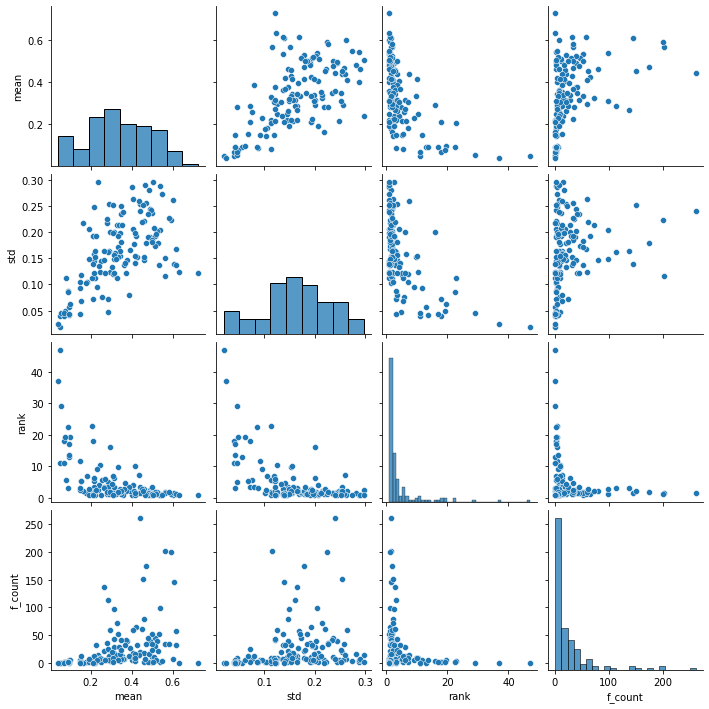

In [23]:
sns.pairplot(per_bird_stat)

In [26]:
!ls

ActivationStudy.ipynb  data2021        maxpool_pred.csv
baseline_pred.csv      eff_pred.csv    maxpool_stat.csv
baseline_stat.csv      eff_stat.csv    StatStudy.ipynb
birdclef-2022.zip      focal_pred.csv  submit
birdclef.ipynb	       focal_stat.csv  Untitled.ipynb
birdclef-submit.ipynb  Lab02_NMT
data		       Lab02_NMT.zip


In [27]:
stat_dict = {
    model: pd.read_csv(f'{model}_stat.csv', index_col=0) for model in ['maxpool', 'focal', 'baseline', 'eff']
}

In [28]:
global_target = np.array([t for t in train_meta.target])
bird_ratio = global_target.mean(axis=0)

In [30]:
for model, stat in stat_dict.items():
    stat.reset_index(inplace=True)
    stat['proportion'] = stat.bird.apply(lambda x: bird_ratio[species2id[x]])
    stat.set_index('bird', inplace=True)
    stat['model'] = model

,mean,std,rank,f_count,proportion,model
bird,,,,,,
afrsil1,0.000641,0.001376,42.000000,1,0.001077,maxpool
akekee,0.134846,0.214917,1.500000,2,0.000404,maxpool
akepa1,0.076107,0.035914,5.555556,9,0.000875,maxpool
akiapo,0.070648,0.053287,8.000000,8,0.001145,maxpool
amewig,0.199945,0.183996,3.363636,11,0.004377,maxpool
...,...,...,...,...,...,...
whttro,0.091122,0.086129,22.500000,2,0.001549,eff
wiltur,0.226920,0.193444,2.606061,33,0.005656,eff
yebcar,0.724870,0.120903,1.000000,1,0.001347,eff


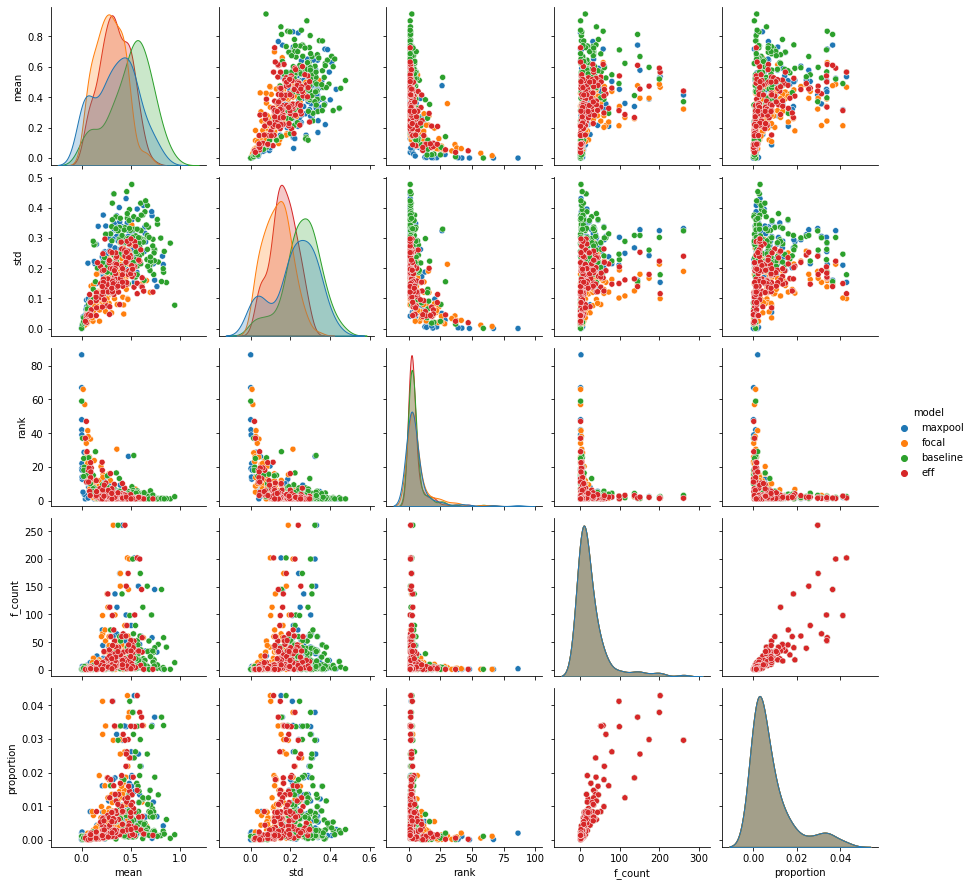

In [36]:
sns.pairplot(
    pd.concat(stat_dict.values()),
    hue='model',
)

In [37]:
pred_pd = pd.read_csv('eff_pred.csv')

In [40]:
(pred_pd.pred > 0.1).sum()

127819